In [166]:
import csv
import pandas as pd
from datetime import datetime
from Levenshtein import distance as levenshtein_distance
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statistics
from fitter import Fitter
import itertools
import multiprocessing
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import shapiro
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

In [167]:
events_final = pd.read_csv('truncated_events_final_twoday.csv') 
print(events_final)

       patientid                       events            starttime
0       10002013                        CSURG  2160-05-18 01:49:32
1       10002013                          ABG  2160-05-18 09:19:00
2       10002013                          CBC  2160-05-18 09:19:00
3       10002013                      Calcium  2160-05-18 09:19:00
4       10002013                 Electrolytes  2160-05-18 09:19:00
...          ...                          ...                  ...
82345   19995790         Sodium Chloride 0.9%  2185-02-03 17:00:00
82346   19995790  Sodium Chloride 0.9%  Flush  2185-02-03 17:00:00
82347   19995790              Docusate Sodium  2185-02-03 20:00:00
82348   19995790                   Metoprolol  2185-02-03 20:00:00
82349   19995790                   Ranitidine  2185-02-03 20:00:00

[82350 rows x 3 columns]


In [168]:

events_final['starttime'] = pd.to_datetime(events_final['starttime'])

In the next step, we will start to generat the trace

In [169]:

traces = events_final.groupby('patientid')['events'].apply(list).reset_index()
traces['starttimes'] = events_final.groupby('patientid')['starttime'].apply(list).reset_index(drop=True)

In [170]:
print(traces.head())
traces.to_csv('traces.csv', index=False)

   patientid                                             events  \
0   10002013  [CSURG, ABG, CBC, Calcium, Electrolytes, Gluco...   
1   10011398  [CSURG, ABG, CBC, Calcium, Electrolytes, Gluco...   
2   10023771  [CSURG, ABG, CBC, Calcium, Electrolytes, Gluco...   
3   10033786  [CSURG, ABG, CBC, Calcium, Electrolytes, Gluco...   
4   10039688  [CSURG, ABG, CBC, Calcium, Electrolytes, Gluco...   

                                          starttimes  
0  [2160-05-18 01:49:32, 2160-05-18 09:19:00, 216...  
1  [2146-12-15 04:53:55, 2146-12-15 07:52:00, 214...  
2  [2113-08-25 03:17:43, 2113-08-25 07:29:00, 211...  
3  [2118-01-16 06:35:16, 2118-01-16 12:00:00, 211...  
4  [2147-05-31 02:31:44, 2147-05-31 07:57:00, 214...  


In [171]:
print(traces['events'].dtype)

object


In [172]:
first_line = traces.iloc[1]['events']
second_line = traces.iloc[2]['events']
print(traces.iloc[1]['events'])
print(traces.iloc[2]['events'])

['CSURG', 'ABG', 'CBC', 'Calcium', 'Electrolytes', 'Glucose', 'ABG', 'CBC', 'Electrolytes', 'Glucose', 'Aspirin', 'ABG', 'CBC', 'Electrolytes', 'Glucose', '5% Dextrose', 'Acetaminophen', 'Calcium Gluconate', 'Dextrose 50%', 'Glycopyrrolate', 'Influenza Vaccine', 'Insulin', 'Lactated Ringers', 'Magnesium Sulfate', 'Metoclopramide', 'Milk of Magnesia', 'Neostigmine', 'Nitroglycerin', 'Opioid', 'Oxycodone-Acetaminophen', 'PHENYLEPHrine', 'Pneumococcal Vaccine', 'Potassium Chloride', 'Propofol', 'Sodium Chloride 0.9%', 'Sodium Chloride 0.9%  Flush', 'Sterile Water', 'ABG', 'CBC', 'Calcium', 'Electrolytes', 'Glucose', 'CBC', 'CefazoLIN', 'Sodium Chloride 0.9%', 'Bicarbonate', 'CBC', 'Creatinine', 'Electrolytes', 'Urea Nitrogen', 'ABG', 'Calcium', 'Electrolytes', 'Glucose', 'ABG', 'Calcium', 'Electrolytes', 'Glucose', 'Ketorolac', 'ABG', 'Electrolytes', 'Glucose', 'CBC', 'Electrolytes', 'Ondansetron', 'Albumin', 'Chlorhexidine Gluconate 0.12% Oral Rinse', 'Docusate Sodium', 'Ranitidine', 'Li

In [173]:
def calculate_hamming_distance(list1, list2, pad_value=None):

    max_len = max(len(list1), len(list2))
    list1_padded = list1 + [pad_value] * (max_len - len(list1))
    list2_padded = list2 + [pad_value] * (max_len - len(list2))
    

    distance = sum(el1 != el2 for el1, el2 in zip(list1_padded, list2_padded))
    return distance

In [174]:

list1 = ['A','B','C','D']
list2 =['A','C','D']


hamming_distance_example = calculate_hamming_distance(list1, list2, pad_value='')
print(f"Hamming distance between list1 and list2: {hamming_distance_example}")

levenshtein_distance_example = levenshtein_distance(list1, list2)
print(f"levenshtein distance between list1 and list2: {levenshtein_distance_example}")

Hamming distance between list1 and list2: 3
levenshtein distance between list1 and list2: 1


In [175]:
first_line = traces.iloc[1]['events']
second_line = traces.iloc[2]['events']
print(traces.iloc[1]['events'])
print(traces.iloc[2]['events'])
print(len(traces.iloc[1]['events']))
print(len(traces.iloc[2]['events']))
hamming_distance_1_2 = calculate_hamming_distance(first_line, second_line)
levenshtein_distance_1_2 = levenshtein_distance(first_line, second_line)
print(f"Hamming distance between the first and second lines: {hamming_distance_1_2}")
print(f"Levenshtein distance between the first and second lines: {levenshtein_distance_1_2}")

['CSURG', 'ABG', 'CBC', 'Calcium', 'Electrolytes', 'Glucose', 'ABG', 'CBC', 'Electrolytes', 'Glucose', 'Aspirin', 'ABG', 'CBC', 'Electrolytes', 'Glucose', '5% Dextrose', 'Acetaminophen', 'Calcium Gluconate', 'Dextrose 50%', 'Glycopyrrolate', 'Influenza Vaccine', 'Insulin', 'Lactated Ringers', 'Magnesium Sulfate', 'Metoclopramide', 'Milk of Magnesia', 'Neostigmine', 'Nitroglycerin', 'Opioid', 'Oxycodone-Acetaminophen', 'PHENYLEPHrine', 'Pneumococcal Vaccine', 'Potassium Chloride', 'Propofol', 'Sodium Chloride 0.9%', 'Sodium Chloride 0.9%  Flush', 'Sterile Water', 'ABG', 'CBC', 'Calcium', 'Electrolytes', 'Glucose', 'CBC', 'CefazoLIN', 'Sodium Chloride 0.9%', 'Bicarbonate', 'CBC', 'Creatinine', 'Electrolytes', 'Urea Nitrogen', 'ABG', 'Calcium', 'Electrolytes', 'Glucose', 'ABG', 'Calcium', 'Electrolytes', 'Glucose', 'Ketorolac', 'ABG', 'Electrolytes', 'Glucose', 'CBC', 'Electrolytes', 'Ondansetron', 'Albumin', 'Chlorhexidine Gluconate 0.12% Oral Rinse', 'Docusate Sodium', 'Ranitidine', 'Li

In [176]:
num_elements = len(traces)
hamming_distance_matrix = pd.DataFrame(index=range(num_elements), columns=range(num_elements))


for i in range(num_elements):
    for j in range(num_elements):
        hamming_distance = calculate_hamming_distance(traces.at[i, "events"], traces.at[j, "events"])
        hamming_distance_matrix.at[i, j] = hamming_distance


print(hamming_distance_matrix)

     0    1    2    3   4    5    6    7    8    9    ... 837  838  839  840  \
0      0   99  101  102  99  100   92  107  106  108  ...  84  107  100  110   
1     99    0   83   90  89   92   94   79   87   73  ...  83   83   90  112   
2    101   83    0   90  95   90  101  100   87   82  ...  91   94   93   99   
3    102   90   90    0  86   96   85   94   72   92  ...  90   92   84  108   
4     99   89   95   86   0  102   93   91   91   88  ...  88   87   90  106   
..   ...  ...  ...  ...  ..  ...  ...  ...  ...  ...  ...  ..  ...  ...  ...   
842   95   98   96   88  98   92   96   95   99  103  ...  92  103   83  107   
843   96   84   80   89  89  102   95   95  100   95  ...  92   97   96  108   
844  100   87   87   78  86  101   97   94   73   86  ...  89   86   77  104   
845  111  100  100   83  95  105  108   97   91   96  ...  97   93   94  109   
846  107   83  101   83  92   94   98   58   75   74  ...  83   63   91  111   

     841  842  843  844  845  846  
0  

In [177]:

hamming_row_averages = hamming_distance_matrix.mean(axis=1)
print("Hamming row averages:")
print(hamming_row_averages)

Hamming row averages:
0      103.245573
1       93.701299
2        95.01771
3       90.417946
4       91.929162
          ...    
842     98.734357
843     96.197166
844     90.691854
845     96.344746
846     93.344746
Length: 847, dtype: object


In [178]:

hamming_sorted_row_averages = hamming_row_averages.sort_values(ascending=False)


hamming_reordered_matrix = hamming_distance_matrix.loc[hamming_sorted_row_averages.index]

print("Sorted row averages (descending):")
print(hamming_sorted_row_averages)

print("Reordered Hamming distance matrix:")
print(hamming_reordered_matrix)

Sorted row averages (descending):
333    156.827627
416    143.736718
645    142.950413
80     136.506494
460    132.099174
          ...    
21      88.543093
340      88.36954
627      88.31523
243     88.282172
430     87.879575
Length: 847, dtype: object
Reordered Hamming distance matrix:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
333  148  154  151  156  155  158  139  160  162  162  ...  153  159  154   
416  146  139  144  138  146  143  141  147  143  142  ...  143  143  142   
645  140  139  123  136  142  152  133  149  149  139  ...  140  146  144   
80   137  141  134  133  140  137  136  142  142  142  ...  139  143  139   
460  126  117  133  137  136  134  134  130  135  129  ...  128  121  134   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
21   104   90   93   76   86  105  100   89   80   84  ...   88   74   88   
340   98   87   82   77   87  104  101   89   80   76  ...   83   80   88   
627  102   88

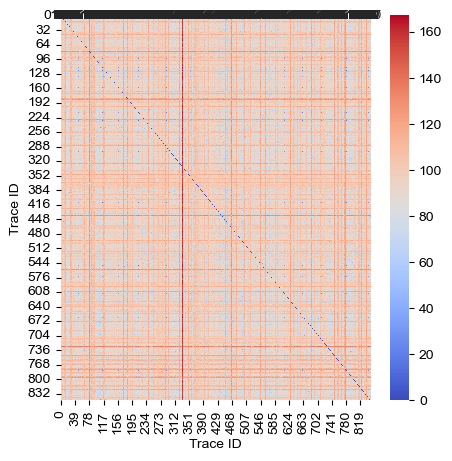

In [179]:
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(hamming_distance_matrix.astype(float), annot=True, cmap='coolwarm', fmt='g')

#plt.title('Heatmap of Hamming Distance Matrix(48hour)', fontsize=12, fontweight='bold')
plt.xlabel('Trace ID', fontsize=10)
plt.ylabel('Trace ID', fontsize=10)
plt.savefig('eFigure1_Heatmap of Hamming Distance Matrix(48hour).png', format='png', dpi=300)
plt.show()

In [180]:
levenshtein_distance_matrix = pd.DataFrame(index=range(num_elements), columns=range(num_elements))


for i in range(num_elements):
    for j in range(num_elements):
        dist = levenshtein_distance(traces.at[i, "events"], traces.at[j, "events"])
        levenshtein_distance_matrix.at[i, j] = dist


print(levenshtein_distance_matrix)

    0   1   2   3   4   5   6   7   8   9    ... 837 838 839 840 841 842 843  \
0     0  48  53  49  62  55  59  42  42  49  ...  56  54  41  76  93  60  57   
1    48   0  45  53  52  64  64  29  29  39  ...  45  48  51  63  82  64  61   
2    53  45   0  39  43  54  61  38  36  39  ...  36  54  52  64  84  59  55   
3    49  53  39   0  57  52  52  43  43  50  ...  39  56  43  77  67  53  47   
4    62  52  43  57   0  71  75  45  40  49  ...  45  45  63  53  76  76  72   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
842  60  64  59  53  76  48  52  64  63  63  ...  65  73  51  83  87   0  45   
843  57  61  55  47  72  46  45  62  63  64  ...  57  71  51  83  84  45   0   
844  47  36  45  48  34  64  71  30  31  38  ...  50  33  49  54  73  68  71   
845  91  81  80  63  75  85  88  79  74  78  ...  72  75  78  91  16  83  76   
846  45  33  40  44  49  61  68  30  26  32  ...  43  41  44  61  75  62  63   

    844 845 846  
0    47  91  45  
1  

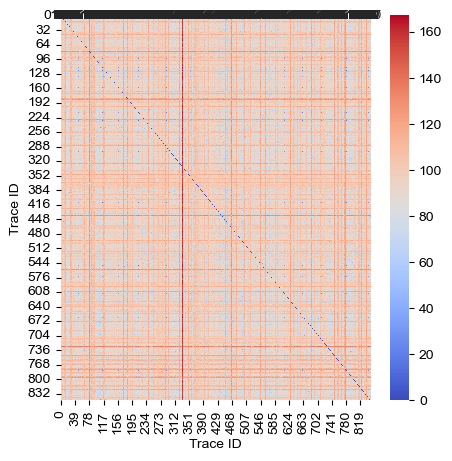

In [181]:
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(hamming_distance_matrix.astype(float), annot=True, cmap='coolwarm', fmt='g')

#plt.title('Heatmap of Levenshtein Distance Matrix(48hour)', fontsize=12, fontweight='bold')
plt.xlabel('Trace ID', fontsize=10)
plt.ylabel('Trace ID', fontsize=10)
plt.savefig('eFigure2_Heatmap of Levenshtein Distance Matrix(48hour).png', format='png', dpi=300)
plt.show()

In [182]:

levenshtein_row_averages = levenshtein_distance_matrix.mean(axis=1)


print("Levenshtein row averages:")
print(levenshtein_row_averages)

Levenshtein row averages:
0      59.413223
1      55.663518
2      54.458087
3      53.884298
4      54.362456
         ...    
842    67.377804
843    64.060213
844    49.855962
845    77.593861
846     52.85242
Length: 847, dtype: object


In [183]:
levenshtein_averages = levenshtein_row_averages.tolist()
levenshtein_averages = pd.DataFrame(levenshtein_row_averages, columns=['variation distance'])

print("Levenshtein averages:")
print(levenshtein_averages)

Levenshtein averages:
    variation distance
0            59.413223
1            55.663518
2            54.458087
3            53.884298
4            54.362456
..                 ...
842          67.377804
843          64.060213
844          49.855962
845          77.593861
846           52.85242

[847 rows x 1 columns]


In [184]:

levenshtein_sorted_row_averages = levenshtein_row_averages.sort_values(ascending=False)


levenshtein_reordered_matrix = levenshtein_distance_matrix.loc[levenshtein_sorted_row_averages.index]

print("Sorted row averages (descending):")
print(levenshtein_sorted_row_averages)

print("Reordered Levenshtein distance matrix:")
print(levenshtein_reordered_matrix)

Sorted row averages (descending):
333    108.760331
416    102.580874
645     97.325856
94      97.158205
299     96.727273
          ...    
394     48.802834
734     48.743802
202     48.674144
749     48.330579
497     47.977568
Length: 847, dtype: object
Reordered Levenshtein distance matrix:
     0    1    2   3    4    5    6    7    8    9    ... 837  838  839  840  \
333   92  111   91  95  116  101   93  111  107  103  ...  89  114  100  121   
416   95   96   87  99  105  105  106   96   96   98  ...  82   95  101  106   
645   86   95   80  94   99   92   81   87   90   91  ...  82   95   97   99   
94   111  100  102  84   95  107  107   97   91   96  ...  98   94   96  112   
299  110   99  102  83   94  106  108   97   90   96  ...  98   94   95  113   
..   ...  ...  ...  ..  ...  ...  ...  ...  ...  ...  ...  ..  ...  ...  ...   
394   37   27   40  43   45   57   67   24   19   22  ...  41   34   47   60   
734   42   35   41  37   44   60   63   27   23   38  ...  39 

In [185]:
temp_distance = levenshtein_sorted_row_averages.reset_index(drop=True)

top_2_5_percentile = np.percentile(temp_distance, 97.5)
top_5_percentile = np.percentile(temp_distance, 95)
top_10_percentile = np.percentile(temp_distance, 90)
top_20_percentile = np.percentile(temp_distance, 80)
bottom_20_percentile = np.percentile(temp_distance, 20)

print(f"Top 2.5% of the list is above: {top_2_5_percentile}")
print(f"22 th: {levenshtein_sorted_row_averages[21]}")
print(f"Top 5% of the list is above: {top_5_percentile}")
print(f"Top 10% of the list is above: {top_10_percentile}")
print(f"Top 20% of the list is above: {top_20_percentile}")
print(f"Bottom 20% of the list is below: {bottom_20_percentile}")

Top 2.5% of the list is above: 82.46322314049587
22 th: 50.39787485242031
Top 5% of the list is above: 78.72231404958677
Top 10% of the list is above: 71.83282172373082
Top 20% of the list is above: 66.30484061393153
Bottom 20% of the list is below: 54.37473435655254


In [186]:
if not levenshtein_sorted_row_averages.index.equals(hamming_sorted_row_averages.index):
    levenshtein_sorted_row_averages_positions = pd.Series(levenshtein_sorted_row_averages.index, name='levenshtein_sorted_row_averages_index')
    hamming_sorted_row_averages_positions = pd.Series(hamming_sorted_row_averages.index, name='hamming_sorted_row_averages_index')

    comparison_df = pd.DataFrame({'levenshtein_sorted_row_averages_position': levenshtein_sorted_row_averages_positions, 'hamming_sorted_row_averages_position': hamming_sorted_row_averages_positions})
    mismatched_positions = comparison_df[levenshtein_sorted_row_averages_positions != hamming_sorted_row_averages_positions]
    display(comparison_df)  
    print("Mismatched indexes and their positions:")
    display(mismatched_positions)  
else:
    print("Both DataFrames have the same index order.")

,levenshtein_sorted_row_averages_position,hamming_sorted_row_averages_position
0,333,333
1,416,416
2,645,645
3,94,80
4,299,460
...,...,...
842,394,21
843,734,340
844,202,627
845,749,243


Mismatched indexes and their positions:


,levenshtein_sorted_row_averages_position,hamming_sorted_row_averages_position
3,94,80
4,299,460
5,395,728
6,467,804
8,550,79
...,...,...
842,394,21
843,734,340
844,202,627
845,749,243


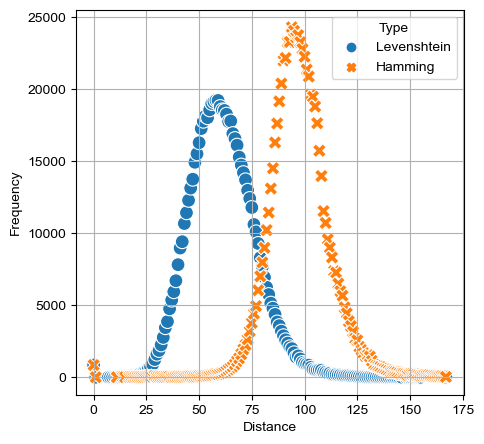

In [187]:
lev_distances = levenshtein_distance_matrix.values.flatten()
ham_distances = hamming_distance_matrix.values.flatten()

lev_unique_distances, lev_counts = np.unique(lev_distances, return_counts=True)
ham_unique_distances, ham_counts = np.unique(ham_distances, return_counts=True)

lev_distance_freq_df = pd.DataFrame({'Distance': lev_unique_distances, 'Frequency': lev_counts, 'Type': 'Levenshtein'})
ham_distance_freq_df = pd.DataFrame({'Distance': ham_unique_distances, 'Frequency': ham_counts, 'Type': 'Hamming'})

distance_freq_df = pd.concat([lev_distance_freq_df, ham_distance_freq_df])


plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=distance_freq_df, x='Distance', y='Frequency', hue='Type', style='Type', s=100)

#plt.title('Frequency Distributions of Hamming and Levenshtein Distance Measurements(48hour)', fontsize=12, fontweight='bold')
plt.xlabel('Distance', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.savefig('eFigure3_Frequency Distributions of Hamming and Levenshtein Distance Measurements(48hour).png', bbox_inches='tight',format='png', dpi=300)
plt.grid(True)
plt.show()

In [188]:
#Select the top 2.5% and bottom 2.5% lists
top_2_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.025))
bottom_2_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.975))

top_2_percent_lists = levenshtein_reordered_matrix.iloc[:top_2_percent_index]
bottom_2_percent_lists = levenshtein_reordered_matrix.iloc[bottom_2_percent_index:]

In [189]:
# Select the top 5% and bottom 5% lists
top_5_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.05))
bottom_5_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.95))

top_5_percent_lists = levenshtein_reordered_matrix.iloc[:top_5_percent_index]
bottom_5_percent_lists = levenshtein_reordered_matrix.iloc[bottom_5_percent_index:]

In [190]:
# Select the top 10% and bottom 10% lists
top_10_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.10))
bottom_10_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.90))

top_10_percent_lists = levenshtein_reordered_matrix.iloc[:top_10_percent_index]
bottom_10_percent_lists = levenshtein_reordered_matrix.iloc[bottom_10_percent_index:]

In [191]:
# Select the top 20% and bottom 20% lists
top_20_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.20))
bottom_20_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.80))

top_20_percent_lists = levenshtein_reordered_matrix.iloc[:top_20_percent_index]
bottom_20_percent_lists = levenshtein_reordered_matrix.iloc[bottom_20_percent_index:]

In [192]:
print("Top 2.5% lists:")
print(top_2_percent_lists)
print("Bottom 2.5% lists:")
print(bottom_2_percent_lists)

top_2_percent_index = top_2_percent_lists.index.tolist()
print("PatientID of Top 2.5% traces:")
print(top_2_percent_lists.index.tolist())
bottom_2_percent_index = bottom_2_percent_lists.index.tolist()
print("PatientID of Bottom 2.5% traces:")
print(bottom_2_percent_lists.index.tolist())

Top 2.5% lists:
     0    1    2   3    4    5    6    7    8    9    ... 837  838  839  840  \
333   92  111   91  95  116  101   93  111  107  103  ...  89  114  100  121   
416   95   96   87  99  105  105  106   96   96   98  ...  82   95  101  106   
645   86   95   80  94   99   92   81   87   90   91  ...  82   95   97   99   
94   111  100  102  84   95  107  107   97   91   96  ...  98   94   96  112   
299  110   99  102  83   94  106  108   97   90   96  ...  98   94   95  113   
395   97  100   91  93   95  100   92  100  103   97  ...  88   95   98  102   
467   79   91   82  78   91   72   70   95   91   92  ...  85   94   73   93   
440   90   93   75  85   79   89   88   91   89   88  ...  76   82   98   85   
550  102   90   91  74   84   96   97   87   81   85  ...  88   84   87  103   
213  100   89   92  74   82   97   99   86   80   84  ...  88   84   86  103   
80    83   86   67  81   85   78   80   82   80   78  ...  69   87   89   91   
168   99   88   91  75  

In [193]:
complete_patients_clinical = pd.read_csv('completepatients.csv')
complete_patients = pd.concat([complete_patients_clinical,levenshtein_averages], axis=1)
print(complete_patients.head())

   subject_id   hadm_id  age gender insurance language                race  \
0    10002013  23581541   57      F  Medicare  ENGLISH               OTHER   
1    10011398  27505812   67      M     Other  ENGLISH  HISPANIC OR LATINO   
2    10023771  20044587   70      M  Medicare  ENGLISH               WHITE   
3    10033786  27383470   50      M     Other  ENGLISH               WHITE   
4    10039688  26345871   63      F  Medicare  ENGLISH               WHITE   

  marital_status  myocardial_infarct  congestive_heart_failure  ...  \
0         SINGLE                   1                         1  ...   
1        MARRIED                   0                         0  ...   
2        MARRIED                   0                         0  ...   
3        MARRIED                   0                         0  ...   
4        MARRIED                   1                         0  ...   

   renal_disease  malignant_cancer  severe_liver_disease  \
0              0                 0          

In [194]:
#print(complete_patients.dtypes)
complete_patients['distance'] = pd.to_numeric(complete_patients['variation distance'], errors='coerce')

In [195]:
complete_patients['age_group'] = pd.cut(complete_patients['age'], bins=[20, 30, 40, 50, 60, 70, 80, 90, 100],
                         labels=['20-30', '31-40', '41-50', '51-60', '61-70','71-80','81-90','91-100'])

In [196]:
def categorize_cci(cci):
    if 10 <= cci <= 12:
        return '10-12'
    elif 8 <= cci < 10:
        return '8-10'
    elif 6 <= cci < 8:
        return '6-8'
    elif 4 <= cci < 6:  
        return '4-6'
    elif 2 <= cci < 4:  
        return '2-4'
    elif 0 <= cci < 2:
        return '0-2'
complete_patients['cci_group'] = complete_patients['cci'].apply(categorize_cci)

In [197]:
def categorize_distance(distance):
    if distance >= 66.30:  
        return 'top20%'
    else:
        return 'Other'
complete_patients['distance_group'] = complete_patients['distance'].apply(categorize_distance)

In [198]:
print(complete_patients.head())
#complete_patients.to_csv('test.csv',index = False)
value_counts = complete_patients['distance_group'].value_counts()
print(value_counts)

   subject_id   hadm_id  age gender insurance language                race  \
0    10002013  23581541   57      F  Medicare  ENGLISH               OTHER   
1    10011398  27505812   67      M     Other  ENGLISH  HISPANIC OR LATINO   
2    10023771  20044587   70      M  Medicare  ENGLISH               WHITE   
3    10033786  27383470   50      M     Other  ENGLISH               WHITE   
4    10039688  26345871   63      F  Medicare  ENGLISH               WHITE   

  marital_status  myocardial_infarct  congestive_heart_failure  ...  aids  \
0         SINGLE                   1                         1  ...     0   
1        MARRIED                   0                         0  ...     0   
2        MARRIED                   0                         0  ...     0   
3        MARRIED                   0                         0  ...     0   
4        MARRIED                   1                         0  ...     0   

   cci  in_hospital_mortality  died_within_30_days  length_of_stay  

In [199]:
complete_patients['race'] = complete_patients['race'].str.split(' ').str[0]
complete_patients['race']= complete_patients['race'].replace(['BLACK/AFRICAN', 'BLACK/CARIBBEAN','BLACK/CAPE','HISPANIC/LATINO','HISPANIC','PATIENT', 'UNABLE','SOUTH','PORTUGUESE','MULTIPLE','OTHER','ASIAN','UNKNOWN'], 'OTHER')
value_counts_race = complete_patients['race'].value_counts()
print(value_counts_race)

race
WHITE    667
OTHER    180
Name: count, dtype: int64


In [200]:
value_counts_gender = complete_patients['gender'].value_counts()
print(value_counts_gender)
value_counts_insurance = complete_patients['insurance'].value_counts()
print(value_counts_insurance)

gender
M    701
F    146
Name: count, dtype: int64
insurance
Other       506
Medicare    313
Medicaid     28
Name: count, dtype: int64


In [201]:
y = complete_patients['length_of_stay']
model = smf.ols('y ~ distance_group + age + cci + C(gender) + C(insurance) + C(race)', data=complete_patients).fit()
print(model.summary())
residuals = model.resid
exog = model.model.exog
s, p = shapiro(residuals)
print('Shapiro-Wilk p:', p)
breuschpagan_test = het_breuschpagan(residuals, exog)
name = ['lm', 'lm_pvalue', 'fvalue', 'f_pvalue']
print(dict(zip(name, breuschpagan_test)))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     24.06
Date:                Mon, 21 Jul 2025   Prob (F-statistic):           6.02e-30
Time:                        16:46:44   Log-Likelihood:                -4757.2
No. Observations:                 847   AIC:                             9530.
Df Residuals:                     839   BIC:                             9568.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [202]:
gamma_model = smf.glm(
    formula='length_of_stay ~ distance_group + age + cci + C(gender) + C(insurance) + C(race)',
    data=complete_patients,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit()

print(gamma_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         length_of_stay   No. Observations:                  847
Model:                            GLM   Df Residuals:                      839
Model Family:                   Gamma   Df Model:                            7
Link Function:                    log   Scale:                         0.15888
Method:                          IRLS   Log-Likelihood:                -4409.4
Date:                Mon, 21 Jul 2025   Deviance:                       86.949
Time:                        16:46:44   Pearson chi2:                     133.
No. Iterations:                    12   Pseudo R-squ. (CS):             0.2201
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [203]:
np.exp(gamma_model.params)

Intercept                   156.790943
distance_group[T.top20%]      1.339270
C(gender)[T.M]                0.953623
C(insurance)[T.Medicare]      0.802920
C(insurance)[T.Other]         0.764905
C(race)[T.WHITE]              0.966395
age                           0.998213
cci                           1.064143
dtype: float64

In [204]:
np.exp(gamma_model.conf_int())

,0,1
Intercept,120.912005,203.316453
distance_group[T.top20%],1.250884,1.433902
C(gender)[T.M],0.887112,1.025121
C(insurance)[T.Medicare],0.685086,0.941020
C(insurance)[T.Other],0.655831,0.892120
C(race)[T.WHITE],0.903504,1.033665
age,0.994656,1.001783
cci,1.046372,1.082217


7.845221749996023e-17


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


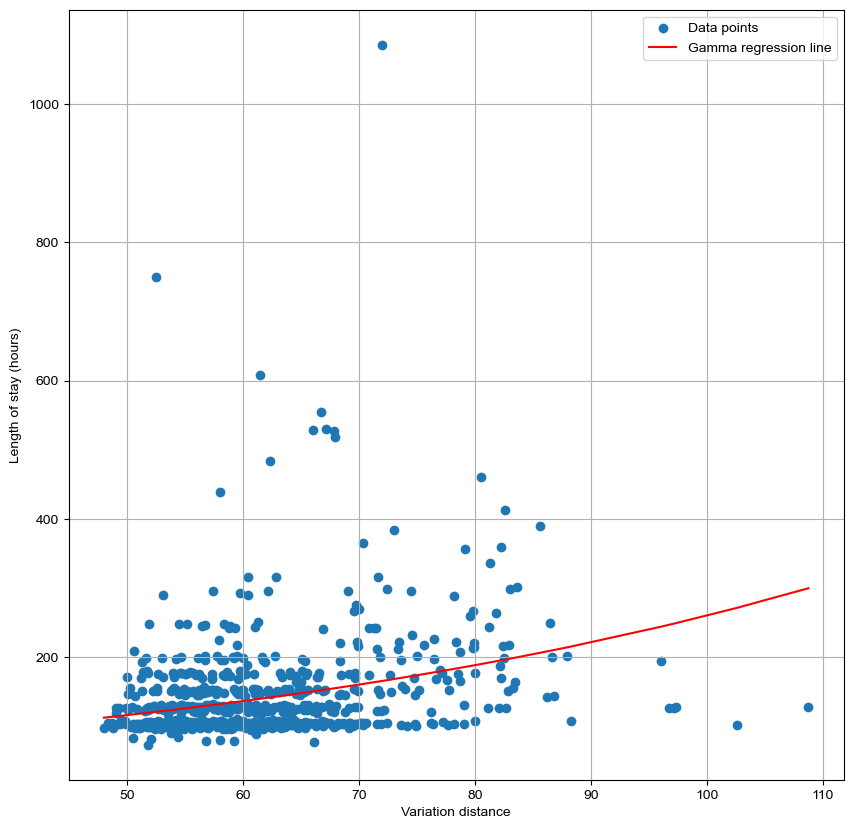

In [205]:
x = complete_patients['variation distance'].astype(float).values
y = complete_patients['length_of_stay'].astype(float).values

#y = complete_patients['length_of_stay'].astype(float).values

X = sm.add_constant(x)

gamma_model = sm.GLM(y, X, family=sm.families.Gamma(sm.families.links.log()))
gamma_results = gamma_model.fit()


x_sorted = np.sort(x)
X_sorted = sm.add_constant(x_sorted)
y_pred = gamma_results.predict(X_sorted)


null_model = sm.GLM(y, np.ones((len(y), 1)), family=sm.families.Gamma(sm.families.links.log())).fit()
pseudo_r2 = 1 - gamma_results.deviance / null_model.deviance


p_value = gamma_results.pvalues[1]
print(p_value)

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x, y,label='Data points')
plt.plot(x_sorted, y_pred, color='red', label='Gamma regression line')

plt.xlabel('Variation distance', fontsize=10)
plt.ylabel('Length of stay (hours)', fontsize=10)
plt.grid(True)

plt.legend()
plt.savefig('Figure_Relationship Between Variation and Length of Stay(48-hour).png',
            bbox_inches='tight', format='png', dpi=800)
plt.show()

In [206]:
print(complete_patients.columns)

Index(['subject_id', 'hadm_id', 'age', 'gender', 'insurance', 'language',
       'race', 'marital_status', 'myocardial_infarct',
       'congestive_heart_failure', 'peripheral_vascular_disease',
       'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease',
       'rheumatic_disease', 'peptic_ulcer_disease', 'mild_liver_disease',
       'diabetes_without_cc', 'diabetes_with_cc', 'paraplegia',
       'renal_disease', 'malignant_cancer', 'severe_liver_disease',
       'metastatic_solid_tumor', 'aids', 'cci', 'in_hospital_mortality',
       'died_within_30_days', 'length_of_stay', 'variation distance',
       'distance', 'age_group', 'cci_group', 'distance_group'],
      dtype='object')


In [207]:
top_2_percent = complete_patients.loc[top_2_percent_index]
print(top_2_percent)
output_path = 'top_2_percent.csv'
top_2_percent.to_csv(output_path, index=False)
top_2_percent_los = top_2_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_2_percent_los}")
top_2_percent_in_hospital_mortality = top_2_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_2_percent_in_hospital_mortality}")
top_2_percent_30_day_mortality = top_2_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_2_percent_30_day_mortality}")
top_2_percent_cci =top_2_percent['cci'].mean()
print(f"The average of CCI is: {top_2_percent_cci}")
top_2_percent_top3cci_averages = top_2_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_2_percent_top3cci = top_2_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_2_percent_top3cci)

     subject_id   hadm_id  age gender insurance language   race  \
333    14195255  27013153   74      M  Medicare  ENGLISH  WHITE   
416    15156174  27191368   51      M     Other  ENGLISH  WHITE   
645    17641873  21705480   81      M     Other  ENGLISH  WHITE   
94     11162509  29912299   69      M     Other  ENGLISH  WHITE   
299    13963514  24742780   49      M     Other  ENGLISH  WHITE   
395    14908025  23478116   60      M     Other  ENGLISH  OTHER   
467    15708357  20482084   52      M  Medicare  ENGLISH  WHITE   
440    15417736  23735688   62      F  Medicare  ENGLISH  OTHER   
550    16586569  27860825   75      M  Medicare        ?  WHITE   
213    12751607  27588222   58      M     Other  ENGLISH  WHITE   
80     11076206  20326682   63      F  Medicare  ENGLISH  WHITE   
168    12241844  23996336   65      M     Other  ENGLISH  OTHER   
460    15610823  26657269   69      F  Medicare  ENGLISH  WHITE   
411    15058789  21706033   65      M  Medicare  ENGLISH  WHIT

In [208]:
# Display the top 5% lists
print("Top 5% lists:")
print(top_5_percent_lists)

# Display the bottom 5% lists
print("Bottom 5% lists:")
print(bottom_5_percent_lists)

top_5_percent_index = top_5_percent_lists.index.tolist()
print("PatientID of Top 5% traces:")
print(top_5_percent_lists.index.tolist())
bottom_5_percent_index = bottom_5_percent_lists.index.tolist()
print("PatientID of Bottom 5% traces:")
print(bottom_5_percent_lists.index.tolist())

Top 5% lists:
     0    1    2   3    4    5    6    7    8    9    ... 837  838  839  840  \
333   92  111   91  95  116  101   93  111  107  103  ...  89  114  100  121   
416   95   96   87  99  105  105  106   96   96   98  ...  82   95  101  106   
645   86   95   80  94   99   92   81   87   90   91  ...  82   95   97   99   
94   111  100  102  84   95  107  107   97   91   96  ...  98   94   96  112   
299  110   99  102  83   94  106  108   97   90   96  ...  98   94   95  113   
395   97  100   91  93   95  100   92  100  103   97  ...  88   95   98  102   
467   79   91   82  78   91   72   70   95   91   92  ...  85   94   73   93   
440   90   93   75  85   79   89   88   91   89   88  ...  76   82   98   85   
550  102   90   91  74   84   96   97   87   81   85  ...  88   84   87  103   
213  100   89   92  74   82   97   99   86   80   84  ...  88   84   86  103   
80    83   86   67  81   85   78   80   82   80   78  ...  69   87   89   91   
168   99   88   91  75   8

In [209]:
# Display the top 10% lists
print("Top 10% lists:")
print(top_10_percent_lists)

# Display the bottom 10% lists
print("Bottom 10% lists:")
print(bottom_10_percent_lists)

top_10_percent_index = top_10_percent_lists.index.tolist()
print("PatientID of Top 10% traces:")
print(top_10_percent_lists.index.tolist())
bottom_10_percent_index = bottom_10_percent_lists.index.tolist()
print("PatientID of Bottom 10% traces:")
print(bottom_10_percent_lists.index.tolist())

Top 10% lists:
     0    1    2   3    4    5    6    7    8    9    ... 837  838  839  840  \
333   92  111   91  95  116  101   93  111  107  103  ...  89  114  100  121   
416   95   96   87  99  105  105  106   96   96   98  ...  82   95  101  106   
645   86   95   80  94   99   92   81   87   90   91  ...  82   95   97   99   
94   111  100  102  84   95  107  107   97   91   96  ...  98   94   96  112   
299  110   99  102  83   94  106  108   97   90   96  ...  98   94   95  113   
..   ...  ...  ...  ..  ...  ...  ...  ...  ...  ...  ...  ..  ...  ...  ...   
107   60   57   66  66   72   65   65   62   63   68  ...  73   73   59   76   
560   69   69   63  73   57   81   82   66   67   69  ...  66   51   76   73   
822   67   69   48  59   72   55   64   67   68   63  ...  53   77   66   81   
203   73   69   62  70   61   63   77   67   68   72  ...  69   60   72   63   
104   56   64   62  59   76   57   68   62   64   67  ...  66   76   43   73   

     841  842  843  844 

In [210]:
# Display the top 20% lists
print("Top 20% lists:")
print(top_20_percent_lists)

# Display the bottom 20% lists
print("Bottom 20% lists:")
print(bottom_20_percent_lists)

top_20_percent_index = top_20_percent_lists.index.tolist()
print("PatientID of Top 20% traces:")
print(top_20_percent_lists.index.tolist())
bottom_20_percent_index = bottom_20_percent_lists.index.tolist()
print("PatientID of Bottom 20% traces:")
print(bottom_20_percent_lists.index.tolist())

Top 20% lists:
     0    1    2   3    4    5    6    7    8    9    ... 837  838  839  840  \
333   92  111   91  95  116  101   93  111  107  103  ...  89  114  100  121   
416   95   96   87  99  105  105  106   96   96   98  ...  82   95  101  106   
645   86   95   80  94   99   92   81   87   90   91  ...  82   95   97   99   
94   111  100  102  84   95  107  107   97   91   96  ...  98   94   96  112   
299  110   99  102  83   94  106  108   97   90   96  ...  98   94   95  113   
..   ...  ...  ...  ..  ...  ...  ...  ...  ...  ...  ...  ..  ...  ...  ...   
128   56   63   58  47   72   54   56   61   58   61  ...  62   69   50   80   
612   74   67   70  67   54   83   87   63   58   61  ...  67   56   78   70   
791   54   64   60  53   73   46   57   59   57   60  ...  62   70   46   77   
81    78   66   67  59   61   80   83   64   65   69  ...  64   64   76   79   
482   74   62   58  68   56   74   83   59   64   65  ...  58   60   77   55   

     841  842  843  844 

In [211]:
top_5_percent = complete_patients.loc[top_5_percent_index]
output_path = 'top_5_percent.csv'
top_5_percent.to_csv(output_path, index=False)
top_5_percent_los = top_5_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_5_percent_los}")
top_5_percent_in_hospital_mortality = top_5_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_5_percent_in_hospital_mortality}")
top_5_percent_30_day_mortality = top_5_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_5_percent_30_day_mortality}")
top_5_percent_cci =top_5_percent['cci'].mean()
print(f"The average of CCI is: {top_5_percent_cci}")
top_5_percent_top3cci_averages = top_5_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_5_percent_top3cci = top_5_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_5_percent_top3cci)

The average of LOS is: 209.39534883720927
The average of in_hospital_mortality is: 0.023255813953488372
The average of 30_day_mortality is: 0.023255813953488372
The average of CCI is: 4.348837209302325
Top3 CCI:
myocardial_infarct     0.372093
diabetes_without_cc    0.302326
renal_disease          0.302326
dtype: float64


In [212]:
top_10_percent = complete_patients.loc[top_10_percent_index]
output_path = 'top_10_percent.csv'
top_10_percent.to_csv(output_path, index=False)
top_10_percent_los = top_10_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_10_percent_los}")
top_10_percent_in_hospital_mortality = top_10_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_10_percent_in_hospital_mortality}")
top_10_percent_30_day_mortality = top_10_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_10_percent_30_day_mortality}")
top_10_percent_cci =top_10_percent['cci'].mean()
print(f"The average of CCI is: {top_10_percent_cci}")
top_10_percent_top3cci_averages = top_10_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_10_percent_top3cci = top_10_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_10_percent_top3cci)

The average of LOS is: 200.7656862745098
The average of in_hospital_mortality is: 0.011764705882352941
The average of 30_day_mortality is: 0.011764705882352941
The average of CCI is: 4.588235294117647
Top3 CCI:
diabetes_without_cc    0.400000
renal_disease          0.329412
myocardial_infarct     0.294118
dtype: float64


In [213]:
top_20_percent = complete_patients.loc[top_20_percent_index]
output_path = 'top_20_percent.csv'
top_20_percent.to_csv(output_path, index=False)
top_20_percent_los = top_20_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_20_percent_los}")
top_20_percent_in_hospital_mortality = top_20_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_20_percent_in_hospital_mortality}")
top_20_percent_30_day_mortality = top_20_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_20_percent_30_day_mortality}")
top_20_percent_cci =top_20_percent['cci'].mean()
print(f"The average of CCI is: {top_20_percent_cci}")
top_20_percent_top3cci_averages = top_20_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_20_percent_top3cci = top_20_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_20_percent_top3cci)

The average of LOS is: 184.20009803921567
The average of in_hospital_mortality is: 0.023529411764705882
The average of 30_day_mortality is: 0.023529411764705882
The average of CCI is: 4.435294117647059
Top3 CCI:
diabetes_without_cc    0.400000
myocardial_infarct     0.270588
renal_disease          0.252941
dtype: float64


In [214]:
bottom_5_percent = complete_patients.loc[bottom_5_percent_index]
output_path = 'bottom_5_percent.csv'
bottom_5_percent.to_csv(output_path, index=False)
bottom_5_percent_los = bottom_5_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_5_percent_los}")
bottom_5_percent_in_hospital_mortality = bottom_5_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_5_percent_in_hospital_mortality}")
bottom_5_percent_30_day_mortality = bottom_5_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_5_percent_30_day_mortality}")
bottom_5_percent_cci =bottom_5_percent['cci'].mean()
print(f"The average of CCI is: {bottom_5_percent_cci}")

bottom_5_percent_top3cci_averages = bottom_5_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_5_percent_top3cci = bottom_5_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_5_percent_top3cci)

The average of LOS is: 118.98178294573643
The average of in_hospital_mortality is: 0.0
The average of 30_day_mortality is: 0.0
The average of CCI is: 3.186046511627907
Top3 CCI:
diabetes_without_cc         0.279070
congestive_heart_failure    0.116279
myocardial_infarct          0.093023
dtype: float64


In [215]:
bottom_10_percent = complete_patients.loc[bottom_10_percent_index]
output_path = 'bottom_10_percent.csv'
bottom_10_percent.to_csv(output_path, index=False)
bottom_10_percent_los = bottom_10_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_10_percent_los}")
bottom_10_percent_in_hospital_mortality = bottom_10_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_10_percent_in_hospital_mortality}")
bottom_10_percent_30_day_mortality = bottom_10_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_10_percent_30_day_mortality}")
bottom_10_percent_cci =bottom_10_percent['cci'].mean()
print(f"The average of CCI is: {bottom_10_percent_cci}")

bottom_10_percent_top3cci_averages = bottom_10_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_10_percent_top3cci = bottom_10_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_10_percent_top3cci)

The average of LOS is: 126.03352941176469
The average of in_hospital_mortality is: 0.011764705882352941
The average of 30_day_mortality is: 0.011764705882352941
The average of CCI is: 3.1411764705882352
Top3 CCI:
diabetes_without_cc         0.294118
myocardial_infarct          0.176471
congestive_heart_failure    0.129412
dtype: float64


In [216]:
bottom_20_percent = complete_patients.loc[bottom_20_percent_index]
output_path = 'bottom_20_percent.csv'
bottom_20_percent.to_csv(output_path, index=False)
bottom_20_percent_los = bottom_20_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_20_percent_los}")
bottom_20_percent_in_hospital_mortality = bottom_20_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_20_percent_in_hospital_mortality}")
bottom_20_percent_30_day_mortality = bottom_20_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_20_percent_30_day_mortality}")
bottom_20_percent_cci =bottom_20_percent['cci'].mean()
print(f"The average of CCI is: {bottom_20_percent_cci}")

bottom_20_percent_top3cci_averages = bottom_20_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_20_percent_top3cci = bottom_20_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_20_percent_top3cci)

The average of LOS is: 123.28098039215683
The average of in_hospital_mortality is: 0.0058823529411764705
The average of 30_day_mortality is: 0.0058823529411764705
The average of CCI is: 3.2529411764705882
Top3 CCI:
diabetes_without_cc          0.329412
myocardial_infarct           0.205882
chronic_pulmonary_disease    0.105882
dtype: float64


In [217]:
#X = complete_patients[['age','cci','myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']]

In [218]:
traces_top_2_percent = traces.iloc[top_2_percent_index]
top_2_percent_patient = traces_top_2_percent['patientid']
print(top_2_percent_patient)
events_final_top_2_percent = events_final[events_final['patientid'].isin(top_2_percent_patient)]
print(events_final_top_2_percent)
events_final_top_2_percent.to_csv('events_final_top_2_percent.csv', index=False)

333    14195255
416    15156174
645    17641873
94     11162509
299    13963514
395    14908025
467    15708357
440    15417736
550    16586569
213    12751607
80     11076206
168    12241844
460    15610823
411    15058789
781    19406009
158    12128863
685    18083865
121    11561996
607    17244760
79     11047016
349    14369707
170    12253915
Name: patientid, dtype: int64
       patientid            events           starttime
7742    11047016             CSURG 2179-10-25 05:24:30
7743    11047016           Aspirin 2179-10-25 10:00:00
7744    11047016  Milk of Magnesia 2179-10-25 10:00:00
7745    11047016               ABG 2179-10-25 10:22:00
7746    11047016               CBC 2179-10-25 10:22:00
...          ...               ...                 ...
75981   19406009               CBC 2160-05-01 07:45:00
75982   19406009           Calcium 2160-05-01 07:45:00
75983   19406009      Electrolytes 2160-05-01 07:45:00
75984   19406009           Glucose 2160-05-01 07:45:00
75985   19406

In [219]:
traces_top_5_percent = traces.iloc[top_5_percent_index]
top_5_percent_patient = traces_top_5_percent['patientid']
print(top_5_percent_patient)
events_final_top_5_percent = events_final[events_final['patientid'].isin(top_5_percent_patient)]
print(events_final_top_5_percent)
events_final_top_5_percent.to_csv('events_final_top_5_percent.csv', index=False)

333    14195255
416    15156174
645    17641873
94     11162509
299    13963514
395    14908025
467    15708357
440    15417736
550    16586569
213    12751607
80     11076206
168    12241844
460    15610823
411    15058789
781    19406009
158    12128863
685    18083865
121    11561996
607    17244760
79     11047016
349    14369707
170    12253915
231    12980551
661    17773753
358    14546527
821    19705462
91     11125397
713    18465135
289    13772495
748    18942549
804    19559236
114    11464841
728    18669132
263    13424432
571    16842789
611    17325365
157    12109233
544    16538239
841    19950645
383    14790760
184    12445879
796    19514121
49     10681562
Name: patientid, dtype: int64
       patientid         events           starttime
4846    10681562        Aspirin 2187-02-19 10:00:00
4847    10681562    Bicarbonate 2187-02-19 18:00:00
4848    10681562            CBC 2187-02-19 18:00:00
4849    10681562     Creatinine 2187-02-19 18:00:00
4850    10681562   Ele

In [220]:
traces_bottom_20_percent = traces.iloc[bottom_20_percent_index]
bottom_20_percent_patient = traces_bottom_20_percent['patientid']
print(bottom_20_percent_patient)
events_final_bottom_20_percent = events_final[events_final['patientid'].isin(bottom_20_percent_patient)]
print(events_final_bottom_20_percent)
events_final_bottom_20_percent.to_csv('events_final_bottom_20_percent.csv', index=False)

19     10207476
4      10039688
181    12433413
300    13972633
492    15957588
         ...   
394    14884188
734    18716421
202    12658295
749    18948626
497    16019747
Name: patientid, Length: 170, dtype: int64
       patientid                       events           starttime
313     10033786                        CSURG 2118-01-16 06:35:16
314     10033786                          ABG 2118-01-16 12:00:00
315     10033786                          CBC 2118-01-16 12:00:00
316     10033786                      Calcium 2118-01-16 12:00:00
317     10033786                 Electrolytes 2118-01-16 12:00:00
...          ...                          ...                 ...
82345   19995790         Sodium Chloride 0.9% 2185-02-03 17:00:00
82346   19995790  Sodium Chloride 0.9%  Flush 2185-02-03 17:00:00
82347   19995790              Docusate Sodium 2185-02-03 20:00:00
82348   19995790                   Metoprolol 2185-02-03 20:00:00
82349   19995790                   Ranitidine 2185-02-0